# **Factor Models**


## **Statistical Factors**

**Objective**: To extract latent common factors from stock returns using Principal Component Analysis (PCA) <br>
and evaluate their explanatory power within a factor model framework (e.g., via Fama--MacBeth regressions).


### **Import and clean the data**

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("data/sample_monthly_returns.csv", parse_dates=["date"], low_memory=False)
df["return"] = pd.to_numeric(df["RET"], errors="coerce")
df = df[["date", "TICKER", "return"]].dropna(subset=["return"])

display(df)

series_by_ticker = {}
for t, g in df.groupby("TICKER", sort=True):
    s = g.set_index("date")["return"].sort_index()
    if not s.index.is_unique:
        s = s.groupby(level=0).last()  # handle duplicate dates
    series_by_ticker[t] = s

rets = pd.concat(series_by_ticker, axis=1)
rets.columns.name = None
rets.index.name = "date"

rets = rets.replace([np.inf, -np.inf], np.nan)
rets = rets.loc[:, rets.count() >= 250]  # keep tickers with ≥250 months
rets = rets.dropna(how="any")

display(rets)

,date,TICKER,return
0,2004-01-30,ORCL,0.047619
1,2004-02-27,ORCL,-0.071429
2,2004-03-31,ORCL,-0.067599
3,2004-04-30,ORCL,-0.062500
4,2004-05-28,ORCL,0.013333
...,...,...,...
112079,2024-08-30,TSLA,-0.077390
112080,2024-09-30,TSLA,0.221942
112081,2024-10-31,TSLA,-0.045025
112082,2024-11-29,TSLA,0.381469


,A,AAP,AAPL,ABT,ACGL,ADBE,ADI,ADM,ADP,ADSK,...,WMT,WST,WY,WYNN,XEL,XOM,XRAY,YUM,ZBRA,ZION
date,,,,,,,,,,,,,,,,,,,,,
2004-03-31,-0.074876,0.030925,0.130435,-0.039720,-0.007310,0.055369,-0.037876,-0.019186,-0.007303,0.097010,...,0.004365,0.014100,0.003831,-0.036874,0.030195,-0.013754,0.010991,0.025925,-0.029519,-0.020079
2004-04-30,-0.146064,0.060979,-0.046598,0.077372,-0.046081,0.055980,-0.112685,0.040901,0.043095,0.063134,...,-0.045066,0.043048,-0.090076,0.140857,-0.060640,0.023082,0.093165,0.021058,0.056509,-0.008932
2004-05-28,-0.048501,-0.006489,0.088441,-0.004019,-0.042331,0.075422,0.155164,-0.048690,0.014152,0.070128,...,-0.020000,-0.020361,0.021622,-0.031806,0.015541,0.022797,0.019604,-0.033256,0.103561,0.088885
2004-06-30,0.139300,0.030558,0.159658,-0.010920,0.036922,0.042180,-0.042116,0.009020,-0.054243,0.194646,...,-0.053293,0.112865,0.043651,-0.000776,-0.004267,0.026821,0.055505,-0.007467,0.075668,0.002447
2004-07-30,-0.186817,-0.159801,-0.006146,-0.028214,-0.034604,-0.092903,-0.156754,-0.080453,0.002388,-0.060967,...,0.004738,-0.094563,-0.011407,-0.073777,0.023339,0.042558,-0.066603,0.034121,-0.050230,-0.015460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-28,-0.005981,-0.103482,0.095553,0.016831,-0.016954,0.249078,-0.022645,-0.031871,-0.019721,0.227431,...,0.029653,-0.006095,-0.054612,-0.056703,-0.026916,-0.018250,-0.104963,-0.036164,-0.010918,0.004168
2024-07-31,0.092617,0.003948,0.054411,0.024829,-0.050649,-0.007002,0.013669,0.025806,0.100256,0.000283,...,0.013735,-0.069887,0.118704,-0.074637,0.091181,0.030142,0.089522,0.002793,0.136795,0.191377
2024-08-30,0.010750,-0.284541,0.032286,0.069190,0.180727,0.041258,0.014954,-0.008386,0.050605,0.043956,...,0.128169,0.024366,-0.033690,-0.068703,0.050618,0.002530,-0.068165,0.020778,-0.016544,-0.032901


### **1. Perform PCA on standardized returns**
load the monthly return data, make sure returns are numeric, and remove missing or invalid entries.

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
returns_scaled = scaler.fit_transform(rets)

pca = PCA(n_components=5)
pca.fit(returns_scaled)


PCA(n_components=5)

### **2. Examine the explained variance**

 Report the explained variance ratio of each component and discuss the proportion of total variance captured.

In [3]:
explained_var = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_var)
print("Cumulative:", explained_var.cumsum())

Explained variance ratio: [0.33792992 0.04913575 0.03078258 0.02684057 0.02010419]
Cumulative: [0.33792992 0.38706567 0.41784825 0.44468882 0.464793  ]


### **3. Plot the cumulative variance ratio**

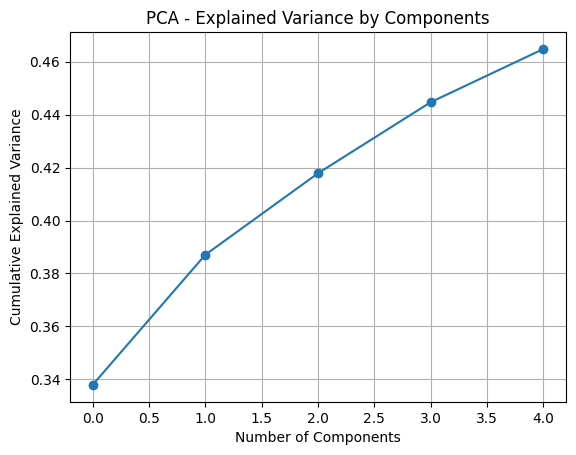

In [4]:
import matplotlib.pyplot as plt

plt.plot(pca.explained_variance_ratio_.cumsum(), marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Explained Variance by Components")
plt.grid(True)
plt.show()


### **4. Construct the factor time series (scores)**
Use the PCA transformation to generate time series of factor scores (the "statistical factors").

In [5]:
factors = pd.DataFrame(
    pca.transform(returns_scaled),
    index=rets.index,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)
display(factors)

,PC1,PC2,PC3,PC4,PC5
date,,,,,
2004-03-31,1.309106,-0.780929,1.218089,0.198656,2.523236
2004-04-30,5.090879,0.662210,-0.128805,0.569639,-8.199310
2004-05-28,-2.203935,1.699293,1.887863,-1.064706,2.804139
2004-06-30,-5.259547,0.802077,1.252675,-2.030383,0.647250
2004-07-30,10.398061,0.941223,-6.567620,-1.238002,4.399977
...,...,...,...,...,...
2024-06-28,4.157819,2.564956,2.433438,0.439597,-0.359391
2024-07-31,-10.074120,-5.234161,-3.156674,4.135982,1.530820
2024-08-30,-2.524103,-6.886800,-1.281700,2.330220,-2.481085


### **5. From 2015 to 2024, estimate monthly betas (factor loadings).**

Run monthly regressions using the previous 10 years (120 months) of observations in order to estimate monthly betas.  <br>
Each regression relates individual stock returns to the PCA factor scores (time series of components).


In [6]:
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

rets.index = pd.to_datetime(rets.index).to_period("M").to_timestamp("M")
factors.index = pd.to_datetime(factors.index).to_period("M").to_timestamp("M")
common = rets.index.intersection(factors.index).sort_values()
rets, factors = rets.loc[common], factors.loc[common]

pc_cols = ["PC1", "PC2", "PC3", "PC4", "PC5"]
X = sm.add_constant(factors[pc_cols])

betas_list = []
window = 120 # Rolling 10-year betas per ticker (120-month window)

for ticker in rets.columns:
    y = rets[ticker]
    model = RollingOLS(y, X, window=window, min_nobs=window)
    res = model.fit()
    df_betas = res.params.copy()              # columns: const, PC1..PC5
    df_betas["TICKER"] = ticker
    df_betas.index.name = "date"
    df_betas["ret"] = y
    betas_list.append(df_betas)

betas = pd.concat(betas_list).reset_index()
betas = betas.dropna()
display(betas)

,date,const,PC1,PC2,PC3,PC4,PC5,TICKER,ret
119,2014-06-30,0.010442,-0.006166,0.000911,0.009647,-0.002761,0.000966,A,0.011099
120,2014-07-31,0.011286,-0.006138,0.000750,0.009927,-0.002633,0.001382,A,-0.023503
121,2014-08-31,0.011845,-0.006107,0.001159,0.009592,-0.002750,-0.000095,A,0.019076
122,2014-09-30,0.013051,-0.006080,0.001197,0.009890,-0.002667,0.000328,A,-0.000840
123,2014-10-31,0.011758,-0.006019,0.001702,0.009497,-0.002890,0.000047,A,-0.029835
...,...,...,...,...,...,...,...,...,...
75635,2024-06-30,0.011050,-0.006365,0.010711,-0.012108,0.011582,0.004095,ZION,0.004168
75636,2024-07-31,0.011727,-0.006438,0.010588,-0.012436,0.012280,0.004228,ZION,0.191377
75637,2024-08-31,0.011557,-0.006435,0.010651,-0.012394,0.012192,0.004309,ZION,-0.032901
75638,2024-09-30,0.010933,-0.006417,0.010679,-0.012368,0.012126,0.003991,ZION,-0.047215


In [7]:
betas["date"] = pd.to_datetime(betas["date"])
betas = betas.set_index(["TICKER", "date"]).sort_index()

display(betas)


const       PC1       PC2       PC3       PC4       PC5  \
TICKER date                                                                     
A      2014-06-30  0.010442 -0.006166  0.000911  0.009647 -0.002761  0.000966   
       2014-07-31  0.011286 -0.006138  0.000750  0.009927 -0.002633  0.001382   
       2014-08-31  0.011845 -0.006107  0.001159  0.009592 -0.002750 -0.000095   
       2014-09-30  0.013051 -0.006080  0.001197  0.009890 -0.002667  0.000328   
       2014-10-31  0.011758 -0.006019  0.001702  0.009497 -0.002890  0.000047   
...                     ...       ...       ...       ...       ...       ...   
ZION   2024-06-30  0.011050 -0.006365  0.010711 -0.012108  0.011582  0.004095   
       2024-07-31  0.011727 -0.006438  0.010588 -0.012436  0.012280  0.004228   
       2024-08-31  0.011557 -0.006435  0.010651 -0.012394  0.012192  0.004309   
       2024-09-30  0.010933 -0.006417  0.010679 -0.012368  0.012126  0.003991   
       2024-10-31  0.011316 -0.006420  0.010665 -0.012486  0.012311  0.004090   

                        ret  
TICKER date                  
A      2014-06-30  0.011099  
       2014-07-31 -0.023503  
       2014-08-31  0.019076  
       2014-09-30 -0.000840  
       2014-10-31 -0.029835  
...                     ...  
ZION   2024-06-30  0.004168  
       2024-07-31  0.191377  
       2024-08-31 -0.032901  
       2024-09-30 -0.047215  
       2024-10-31  0.102499  

[38750 rows x 7 columns]

### **6. Test the factor model using the Fama–MacBeth regression**

In the second-stage cross-sectional regression, test whether the estimated betas explain average returns.

In [8]:
from linearmodels.panel import FamaMacBeth

data = betas.copy()

data[pc_cols] = data.groupby(level=0)[pc_cols].shift(1)

# Keep rows where we have both lagged betas and realized excess returns
data = data.dropna(subset=pc_cols + ["ret"])

y = data["ret"]
X = sm.add_constant(data[pc_cols])

mod = FamaMacBeth(y, X)
fe_res = mod.fit(cov_type="kernel", kernel="bartlett", bandwidth=12)

display(fe_res.summary)

Dep. Variable:,ret,R-squared:,0.0008
Estimator:,FamaMacBeth,R-squared (Between):,0.1915
No. Observations:,38440,R-squared (Within):,-0.0002
Date:,"Mon, Nov 03 2025",R-squared (Overall):,0.0008
Time:,06:06:55,Log-likelihood,4.074e+04
Cov. Estimator:,Fama-MacBeth Kernel Cov,,
,,F-statistic:,5.8995
Entities:,310,P-value,0.0000
Avg Obs:,124.00,Distribution:,"F(5,38434)"
Min Obs:,124.00,,
Max Obs:,124.00,F-statistic (robust):,0.7981
